<center><h1>DeepLabV3 for Semantic Segmentation</h1></center>

*   DeepLabV3 was proposed by some of the top researches at google where they try to rethink and reinvent some of their previous work on deeplabV1 and deeplabV2 network which was mainly created for image segmentation.
*   DeepLabV3 solves the problem that involves signal decimation and learning multi-scale contextual features in the neural network.
*   DeepLabV3 employs atrous convolution in cascade or in parallel to capture the multi-scale context by adopting multiple atrous rates in the network.
More information in Summary of literature survey [here](https://drive.google.com/file/d/1eDDeV-W2C6MhZHuPh1Z4_AFLWB1xTNfW/view?usp=sharing)

<u>**Atrous Convolutions:**</u>
* Atrous or Dilated convolutions is a powerful tool to explicitly adjust filter’s field-of-view as well as control the resolution of feature responses computed by Deep Convolutional Neural Networks.
* Atrous convolution chooses to preserve the feature resolution and some of the spatial information in the Deep neural network.
* Atrous convolutions has a parameter called the dilation rate which defines a spacing between the values in a kernel example,A 3x3 kernel with a dilation rate of 2 will have the same field of view as a 5x5 kernel, but all spacing value are filled by zero.

<img src="https://imgur.com/FDrUVve.png">

<u>**Atrous Spatial Pyramid Pooling:**</u>
<img align="right" src="https://imgur.com/17NWB7X.png">
* The Atrous Spatial Pyramid Pooling(ASPP)  module contains parallel convolutions layer with different atrous rates to captures multi-scale information. 
* The ASPP module has one 1x1 Conv and three 3x3 Conv with the atrous rate of  (6,12,18) and all convolutional layers are followed by batch normalization 
* if the Atrous rate value is close to the feature map size, instead of capturing the whole image context, it simply degenerates to a simple 1 x 1 filter, To overcome this, global average pooling is used before 1x1 Conv in the first layer in Atrous Spatial Pyramid Pooling


<u>**Implementation Detail of DeepLabV3:**</u><br>
* Deeplabv3 can be implemented in various configurations with varying network architecture and with increasing complexity however below is an architecture implemented as in the paper, For more information please refer the paper  [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/pdf/1706.05587.pdf) 
<center><img src="https://imgur.com/U1fmQZp.png"></center>
*   The Deeplabv3 is built by using Restnet50 which has 4 blocks excluding Conv1+ Pool1.
*   Initially Convolution and polling ( Conv1+ Pool1) is performed on the image before it is fed into next block
*	The block 1,2 has output stride of  4,8 and Block 3,4 has output stride=16 respectively
*   Atrous convolution is only used from Block4 that has three 3x3 convolutions as in Restnet50 architecture.
*   Block-4 has multigrid=(1,2,4) with rate=2 {2.(1,2,4)=(2,4,8)} which means the three 3x3 convolutions in the Block-4 has Atrous rate of 2,4,8 respectively
*   The ASPP module performs parallel convolutions with 256 filters and batch normalization each on the output of Block4, First global average pooling followed by 1x1 Conv, second 3x3 Conv with rate=6, third 3x3 Conv with rate=12, fourth  3x3 Conv with rate=18 and the rates are doubled if block4 has output stride=8.
*   After all parallel operations, all feature maps are concatenated and pass through another 1x1 convolution with 256 filters and batch normalization.
*   Finally, the feature maps are upsampled to ground truth resolution and Final prediction is obtained with a softmax layer.

### Importing all modules

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from numpy import asarray,zeros,moveaxis
from tensorflow.keras.initializers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
from sys import getsizeof
from keras.callbacks import TensorBoard
from tqdm import tqdm_notebook,tqdm
from sklearn.metrics import *
import os,sys,ntpath,fnmatch,shutil,cv2
import joblib,os.path,itertools,warnings
from keras.models import load_model 
from scipy.sparse import csc_matrix
import numpy as np
import pandas as pd
from os import path
!pip install import_ipynb
from IPython.display import clear_output
from time import time
np.random.seed(0)
from google.colab import drive
drive.mount('/content/drive')
! cp -v "/content/drive/My Drive/IID_Files/Utility_Functions.ipynb" "/content" 
! cp -v "/content/drive/My Drive/IID_Files/Final.ipynb" "/content" 
! cp -v "/content/drive/My Drive/IID_Files/IID_Data_Prep_Utils.ipynb" "/content"  
warnings.filterwarnings("ignore")
clear_output()

### Importing Data Preparation Modules

In [ ]:
import import_ipynb 
from Utility_Functions import *
from Final import *
from IID_Data_Prep_Utils import *

Checking Status:
------------------------------------------------------
1.Image Data Preparation     .. .. .. >>> |Done| <1/5>
2.Label Mask Preparation     .. .. .. >>> |Done| <2/5>
3.Data Shuffling             .. .. .. >>> |Done| <3/5>
4.Data Train_Test_Split      .. .. .. >>> |Done| <4/5>
5.Loading Final Data         .. .. .. >>> |Done| <5/5>
------------------------------------------------------

Gen RAM Free: 24.23 GB  - Used: 0.37 GB - Total : 25.51 GB - Util  1.45 % 
GPU RAM Free: 15.9 GB  - Used: 0.0 GB - Total : 15.9 GB  - Util  0.0 %  


### General Utility Function for Prediction

In [ ]:
def predict_for(data_for_prediction, weights_save_path=False):

    """  General Function to perform prediction for the specified data split  """

    Mean_MIoU, Accuracy, cf_matrix=[], [], np.zeros((7,7))
    x, y = Load_For_Prediction(data_for_prediction)
    Model, Skip = Select_Model(weights_save_path), 2
    
    for d in tqdm_notebook(range(0,len(x),Skip)):

        if (d>=(len(x)-Skip)): 
            plot,_,_=True,clear_output(),print("Total number of samples in {0} : {1}".format(data_for_prediction,len(x)))
        else: plot=False
        
        Miou, cf_matrix, Accuracy=Function_2(x[d:d+Skip],y[d:d+Skip],Mean_MIoU,cf_matrix,Accuracy,Model,plot,False,False,False)
    collected = gc.collect()
    
    return Miou, Accuracy, cf_matrix

### Implementation of DeepLabV3

In [ ]:
def Deeplab_V3(Input_shape, n_classes):

    """
    Function to build DeeplabV3 Architecture for Image Segmentation
    Input  : input_shape <Tuple>, n_classes <Int>
    Return : model """

    def Restnet_for_Deeplab(Input_layer):

        """
        Function to Build RestNet for DeeplabV3 Architecture to perform Image Segmentation
        Input  : Input_layer <keras.layer>
        Return : Block5_3_ID <keras.layer> """
            
        def Restnet_Conv_Block(Block_Number, Sub_block, Name, Filters, Previous_layer, initialize="he_normal"):

            """
            Function to Build RestNet Convolution Blocks  
            Input  : Block_Number <Int>, Sub_block <Int>, Name <String>, Filters <List>, Previous_layer <keras.layer>, initialize <String>
            Return : Final_Conv <keras.layer> """
            
            # Defining Multi_grid and strides values Based on Block_Number
            Multi_grid, Rate = [1,2,4], 2
            strides=(1,1) if Block_Number==2 or Block_Number==5 else (2,2)        
            
            # Defining Dilated Rate Based on Block_Number and Sub_block
            if (Block_Number==5) and (Sub_block==1):
                D_Rate = Multi_grid[0] * Rate
            elif (Block_Number==5) and (Sub_block==2):
                D_Rate = Multi_grid[1] * Rate
            elif (Block_Number==5) and (Sub_block==3):
                D_Rate = Multi_grid[2] * Rate
            else:D_Rate=1

            # Defining First Convolution layer with Batch Normalization for RestNet Convolution Block  
            Convolution1 = tf.keras.layers.Conv2D(Filters[0],(1,1), strides=strides, name= Name+"Conv1", activation = 'relu', kernel_initializer=initialize)(Previous_layer)
            Batch_norm1=tf.keras.layers.BatchNormalization()(Convolution1)
            
            # Defining Second Convolution layer with Batch Normalization for RestNet Convolution Block  
            Convolution2 = tf.keras.layers.Conv2D(Filters[1],(3,3), dilation_rate=D_Rate, name= Name+"Conv2", padding='same', activation = 'relu', kernel_initializer=initialize)(Batch_norm1)
            Batch_norm2=tf.keras.layers.BatchNormalization()(Convolution2)
            
            # Defining Third Convolution layer with Batch Normalization for RestNet Convolution Block 
            Convolution3 = tf.keras.layers.Conv2D(Filters[2],(1,1),name= Name+"Conv3", activation = None, kernel_initializer=initialize)(Batch_norm2)
            Batch_norm3=tf.keras.layers.BatchNormalization()(Convolution3)
            
            # Defining Convolution layer with Batch Normalization for RestNet Convolution Block   
            Layer_to_add = tf.keras.layers.Conv2D(Filters[2],(1,1), strides=strides, name= Name+"conv_prep_add", activation = None, kernel_initializer=initialize)(Previous_layer)
            Layer_to_add=tf.keras.layers.BatchNormalization()(Layer_to_add)

            # Defining Skip Connection for RestNet Convolution Blocks    
            Added_Layer=tf.keras.layers.add([Batch_norm3,Layer_to_add])
            Final_Conv=tf.keras.layers.Activation("relu")(Added_Layer)
            
            return Final_Conv
            
        def Restnet_Id_Block(Block_Number,Sub_block,Name,Filters,Previous_layer,initialize="he_normal"):

            """
            Function to Build RestNet Identity Blocks  
            Input  : Block_Number <Int>, Sub_block <Int>, Name <String>, Filters <List>, Previous_layer <keras.layer>, initialize <String>
            Return : Final_Conv1 <keras.layer> """
            
            # Defining Multi_grid value Based on Block_Number
            Multi_grid, Rate = [1,2,4], 2
            
            # Defining Dilated Rate Based on Block_Number and Sub_block
            if (Block_Number==5) and (Sub_block==1):
                D_Rate=Multi_grid[0] * Rate
            elif (Block_Number==5) and (Sub_block==2):
                D_Rate=Multi_grid[1] * Rate
            elif (Block_Number==5) and (Sub_block==3):
                D_Rate=Multi_grid[2] * Rate
            else:D_Rate=1

            # Defining First Convolution layer with Batch Normalization for RestNet Identity Block
            Convolution1 = tf.keras.layers.Conv2D(Filters[0], (1,1), name= Name+"Conv1", activation = 'relu', kernel_initializer=initialize)(Previous_layer)
            Batch_norm1=tf.keras.layers.BatchNormalization()(Convolution1)
            
            # Defining Second Convolution layer with Batch Normalization for RestNet Identity Block   
            Convolution2 = tf.keras.layers.Conv2D(Filters[1], (3,3), dilation_rate=D_Rate, name= Name+"Conv2", padding='same', activation = 'relu', kernel_initializer=initialize)(Batch_norm1)
            Batch_norm2=tf.keras.layers.BatchNormalization()(Convolution2)
            
            # Defining Third Convolution layer with Batch Normalization for RestNet Identity Block   
            Convolution3 = tf.keras.layers.Conv2D(Filters[2], (1,1), name= Name+"Conv3", activation = None, kernel_initializer=initialize)(Batch_norm2)
            Batch_norm3=tf.keras.layers.BatchNormalization()(Convolution3)
            
            # Defining Skip Connection for RestNet Identity Block
            Added_Layer=tf.keras.layers.add([Batch_norm3,Previous_layer])
            Final_Conv1=tf.keras.layers.Activation("relu")(Added_Layer)
    
            return Final_Conv1
        
        # Building RestNet Block-1
        Block_1_Conv = tf.keras.layers.Conv2D(64,(7,7),strides=(2,2),name= "Block1_Conv1", activation = 'relu', padding='same', kernel_initializer="he_normal")(Input_layer)
        Block_1_Batch_norm1=tf.keras.layers.BatchNormalization(name="Block1_Conv1_BN")(Block_1_Conv)
        Block_1_MaxPool = tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2), name="Block1_Maxpool1", padding='same')(Block_1_Batch_norm1)

        # Building RestNet Block-2    
        Block2_1_con= Restnet_Conv_Block(2,1,"Block2.1_CONV_", [64,64,256], Block_1_MaxPool)
        Block2_2_ID= Restnet_Id_Block( 2, 2,"Block2.2_ID_",    [64,64,256], Block2_1_con)
        Block2_3_ID= Restnet_Id_Block( 2, 3,"Block2.3_ID_",    [64,64,256], Block2_2_ID)
        
        # Building RestNet Block-3
        Block3_1_con= Restnet_Conv_Block(3, 1,"Block3.1_CONV_", [128,128,512], Block2_3_ID)
        Block3_2_ID= Restnet_Id_Block( 3,   2, "Block3.2_ID_",   [128,128,512], Block3_1_con)
        Block3_3_ID= Restnet_Id_Block( 3,   3, "Block3.3_ID_",   [128,128,512], Block3_2_ID)
        Block3_4_ID= Restnet_Id_Block( 3,   4, "Block3.4_ID_",   [128,128,512], Block3_3_ID)
        
        # Building RestNet Block-4
        Block4_1_con= Restnet_Conv_Block(4, 1, "Block4.1_CONV_", [256,256,1024], Block3_4_ID)
        Block4_2_ID= Restnet_Id_Block( 4,   2, "Block4.2_ID_",   [256,256,1024], Block4_1_con)
        Block4_3_ID= Restnet_Id_Block( 4,   3, "Block4.3_ID_",   [256,256,1024], Block4_2_ID)
        Block4_4_ID= Restnet_Id_Block( 4,   4, "Block4.4_ID_",   [256,256,1024], Block4_3_ID)
        Block4_5_ID= Restnet_Id_Block( 4,   5, "Block4.5_ID_",   [256,256,1024], Block4_4_ID)
        Block4_6_ID= Restnet_Id_Block( 4,   6, "Block4.6_ID_",   [256,256,1024], Block4_5_ID)
        
        # Building RestNet Block-5
        Block5_1_con= Restnet_Conv_Block(5, 1, "Block5.1_CONV_", [512,512,2048], Block4_6_ID)
        Block5_2_ID= Restnet_Id_Block( 5,   2, "Block5.2_ID_",   [512,512,2048], Block5_1_con)
        Block5_3_ID= Restnet_Id_Block( 5,   3, "Block5.3_ID_",   [512,512,2048], Block5_2_ID)
        
        return Block5_3_ID
    
    def Atrous_Spatial_Pyramid_Pooling(Restnet_Block,ASPP_Filter=256):
        
        """
        Function to build Atrous Spatial Pyramid Pooling Module for DeeplabV3 Network
        Input  : Restnet_Block <keras.layer>, ASPP_Filter <Int>
        Return : Output <keras.layer> """

        # Global Average Pooling for ASPP Input Layer 
        G_pool = tf.keras.layers.GlobalAveragePooling2D(name='ASPP_GL_POOL')(Restnet_Block)
        G_pool = tf.keras.layers.Reshape((1,1,Restnet_Block.shape[3]))(G_pool)
        
        # Convolutional layer for oytput of Global Average Pooling layer
        Convolution1 = tf.keras.layers.Conv2D(ASPP_Filter, (1,1), name= "Global_Conv", activation = "relu")(G_pool)
        Batch_norm1  = tf.keras.layers.BatchNormalization()(Convolution1)
        
        # UpSampling Global Features After Global Average Pooling and Convolutional layer
        Global_Features = UpSampling2D( size=(15,30), interpolation='bilinear', name='upsamp')(Batch_norm1)
        
        # Defining Convolution layer with Batch Normalization with Dilation_Rate=1 for ASPP Module
        ASPP_Conv0 = tf.keras.layers.Conv2D(ASPP_Filter, (1,1), name= "ASPP_Conv0_1x1", activation = "relu", padding="same")(Restnet_Block)
        ASPP_Conv0 = tf.keras.layers.BatchNormalization()(ASPP_Conv0)
        
        # Defining Convolution layer with Batch Normalization with Dilation_Rate=6 for ASPP Module
        ASPP_Conv1 = tf.keras.layers.Conv2D(ASPP_Filter, (3,3), name= "ASPP_Conv1_3x3", dilation_rate=6, activation = "relu", padding="same")(Restnet_Block)
        ASPP_Conv1 = tf.keras.layers.BatchNormalization()(ASPP_Conv1)
        
        # Defining Convolution layer with Batch Normalization with Dilation_Rate=12 for ASPP Module
        ASPP_Conv2 = tf.keras.layers.Conv2D(ASPP_Filter, (3,3), name= "ASPP_Conv2_3x3", dilation_rate=12, activation = "relu", padding="same")(Restnet_Block)
        ASPP_Conv2 = tf.keras.layers.BatchNormalization()(ASPP_Conv2)
        
        # Defining Convolution layer with Batch Normalization with Dilation_Rate=18 for ASPP Module
        ASPP_Conv3 = tf.keras.layers.Conv2D(ASPP_Filter, (3,3), name= "ASPP_Conv3_3x3", dilation_rate=18, activation = "relu", padding="same")(Restnet_Block)
        ASPP_Conv3 = tf.keras.layers.BatchNormalization()(ASPP_Conv3)
        
        # Concatenating of all Parallel layers to get Multiscale features
        ASPP_Features= tf.keras.layers.concatenate([Global_Features, ASPP_Conv0, ASPP_Conv1, ASPP_Conv2, ASPP_Conv3])
        
        # Convolution layer with Batch Normalization ASPP_Features
        ASPP_Features = tf.keras.layers.Conv2D(ASPP_Filter, (1,1), name= "ASPP_Out", activation = "relu")(ASPP_Features)
        ASPP_Features = tf.keras.layers.BatchNormalization()(ASPP_Features)
        
        # UpSampling ASPP_Features to Orginal size of Network input
        ASPP_Features = UpSampling2D(size=(16,16), interpolation='bilinear', name='upsampling')(ASPP_Features)
        ASPP_Features = tf.keras.layers.Conv2D(64, (1,1), name= "out", activation = "relu")(ASPP_Features)

        # Final Convolution layer has number of classes as filter size followed by softmax Layer
        ASPP_Features = tf.keras.layers.Conv2D(n_classes, (1,1), name= "output", activation ='relu')(ASPP_Features)
        Output=Activation('softmax', name="Softmax")(ASPP_Features)
        
        return Output
    
    # Defining input layer of DeeplabV3 
    Input_layer = tf.keras.layers.Input(shape=Input_shape)

    # Invoking Restnet_for_Deeplab() for RestNet
    Block5_3_ID = Restnet_for_Deeplab(Input_layer)
    
    # Invoking Atrous_Spatial_Pyramid_Pooling() for ASSP Module
    Output = Atrous_Spatial_Pyramid_Pooling(Block5_3_ID)

    # Defining Model with Input and Output Layer 
    model = Model(inputs=Input_layer, outputs=Output, name="Deeplab_V3")
    
    return model 

# Invoking Deeplab_V3() to get Deeplab_V3 Model
Input_shape, n_classes = (240, 480,3), 7
Deeplab_Model = Deeplab_V3(Input_shape, n_classes)

### Training DeepLabV3 Model

In [ ]:
# Get current Time
start_time = time()

# Defining Batch size and epoch 
batch_size, epochs = 8, 50

# Defining tensorboard to store Training Information and filepath to store DeeplabV3 model 
tensorboard, filepath = TensorBoard(log_dir=root+"logs/Deep_lab_new1{}".format(str(time())[5:10])), root+"/Deeplab.best.hdf5"

# Defining steps_per_epoch and validation_steps for Training
steps_per_epoch, validation_steps = int((len(train_img_files1)+len(train_img_files2))/batch_size), int((len(val_img_files1)+len(val_img_files2))/batch_size)

# Compile DeeplabV3 Model
Deeplab_Model.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = 'categorical_crossentropy',metrics = ['accuracy',miou])

# Defining EarlyStopping with patience=5 and monitor='val_miou'
es = EarlyStopping(monitor='val_miou', mode='max', verbose=1, patience=5)

# Defining ModelCheckpoint with monitor as 'val_miou'
checkpoint = ModelCheckpoint(filepath, monitor='val_miou', verbose=2, save_best_only=True, mode='max')

# Defining ReduceLROnPlateau to reduce learning rate with patience=3  
learning_rate_reduction = ReduceLROnPlateau(monitor='val_miou', patience=3, verbose=2, factor=0.2, min_lr=0.0005)

# Fit DeeplabV3 Model to start training 
history = Deeplab_Model.fit_generator(train_batch_generator(batch_size,epochs), steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, validation_data=val_batch_generator(batch_size,epochs),
                            validation_steps=validation_steps, callbacks=[learning_rate_reduction,checkpoint,es,tensorboard])

# Printing Time taken for Training 
print("--- %s seconds ---" % (time() - start_time))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
   1/1753 [..............................] - ETA: 0s - loss: 1.8052 - accuracy: 0.1404 - miou: 0.0529WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1753/1753 [==============================] - ETA: 0s - loss: 0.5163 - accuracy: 0.8045 - miou: 0.4826
Epoch 00001: val_miou improved from -inf to 0.47972, saving model to /content/drive/My Drive/Deeplab_new1_Model.best.hdf5
1753/1753 [==============================] - 5239s 3s/step - loss: 0.5163 - accuracy: 0.8045 - miou: 0.4826 - val_loss: 0.4977 - val_accuracy: 0.8121 - val_miou: 0.4797
Epoch 2/50
1753/1753 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8457 - miou: 0.5699
Epoch 00002: val_miou improv

### DeepLabV3 Training Results

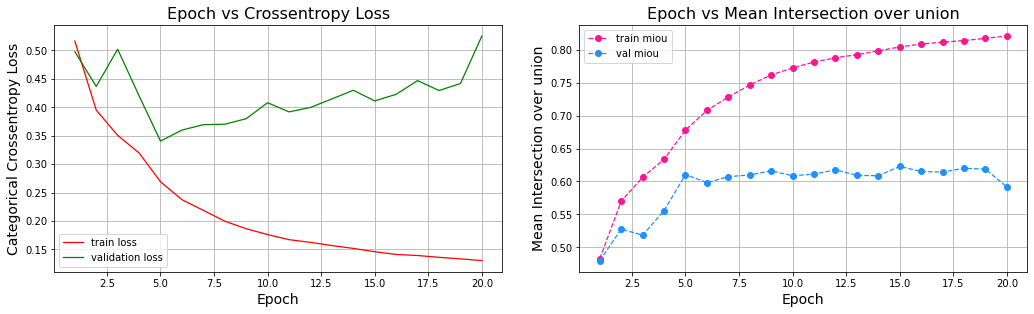

In [ ]:
# Training_result
plot_training_result(history)

* The Lowest value of Validation Categorical Crossentopy is 0.3404 which is at epoch-5 as above in the Graph.
* The Best Value of Validation Mean Intersection Over Union is 0.6229 which is at epoch-15 as above in the Graph.
* Keras callback ModelCheckpoint is used to save the best Model during Training to avoid overfitting.

### DeepLabV3 Prediction on Train Data


Total number of samples in Train_data : 10016

Few Segmentation Samples:>>>



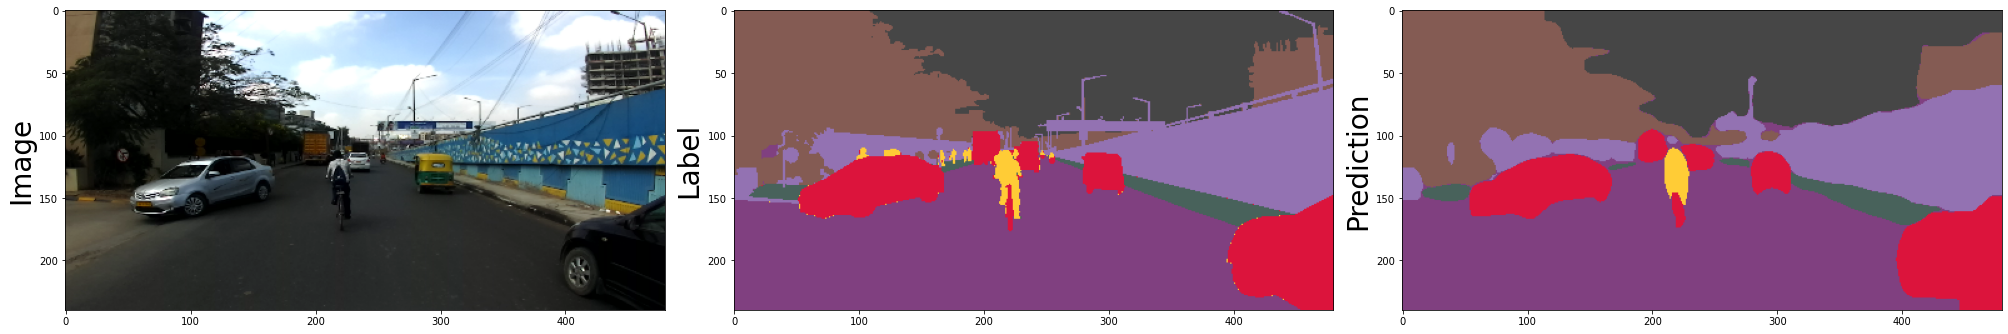

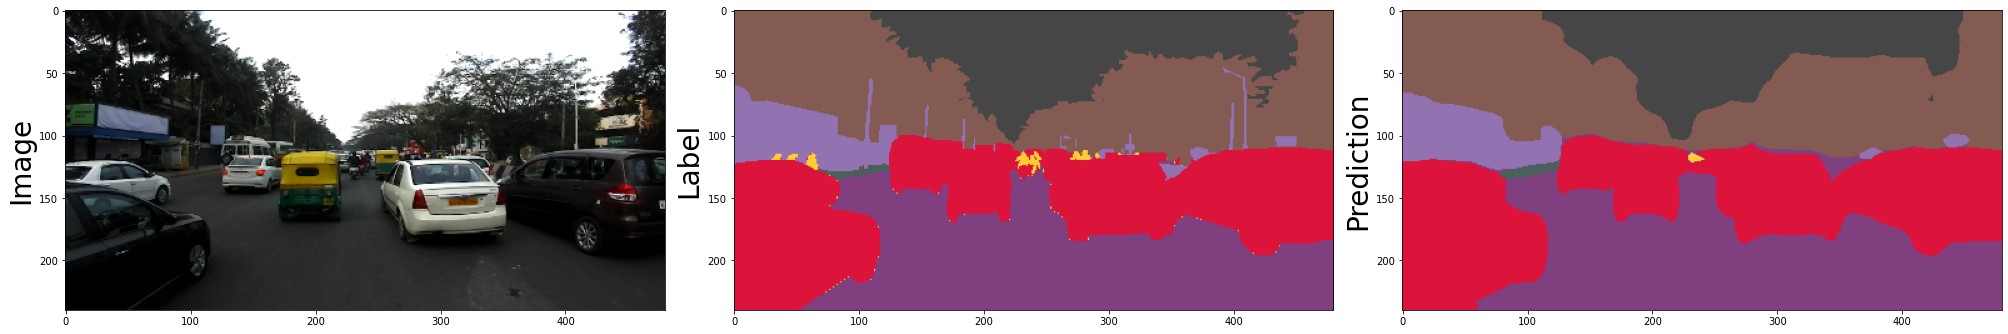


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.6598

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.9279

-----------------------
|  Confusion Matrix   |
-----------------------


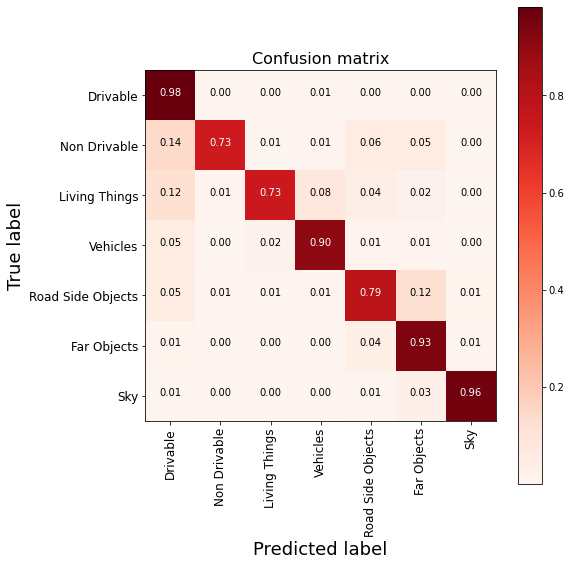

In [ ]:
# Train Prediction 
Miou, Accuracy, cf_matrix = predict_for("Train_data")

### DeepLabV3 Prediction on Validation Data

Total number of samples in Val_data : 2036

Few Segmentation Samples:>>>



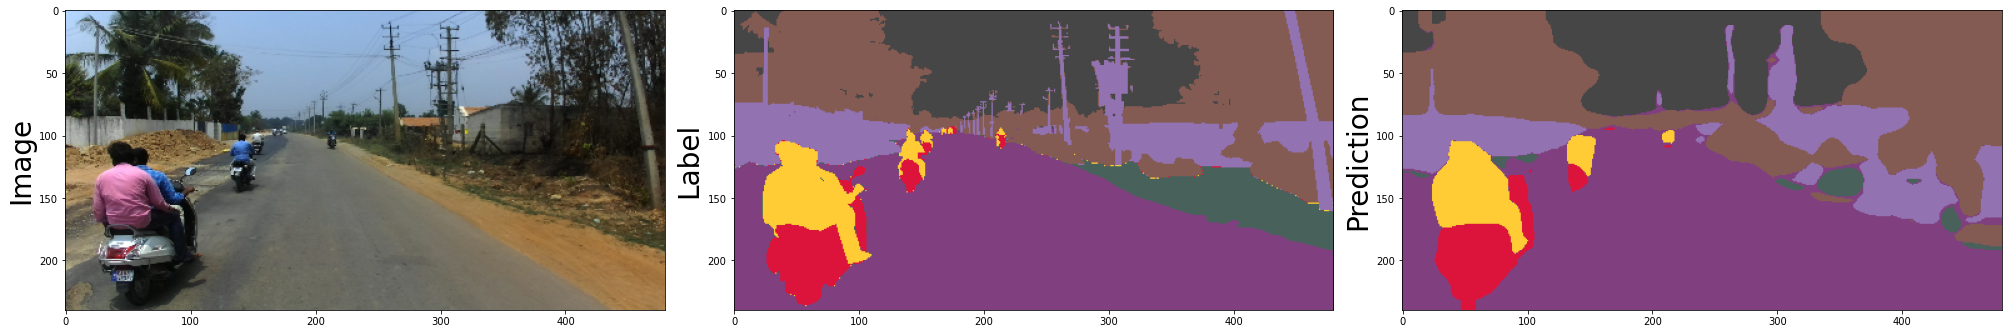

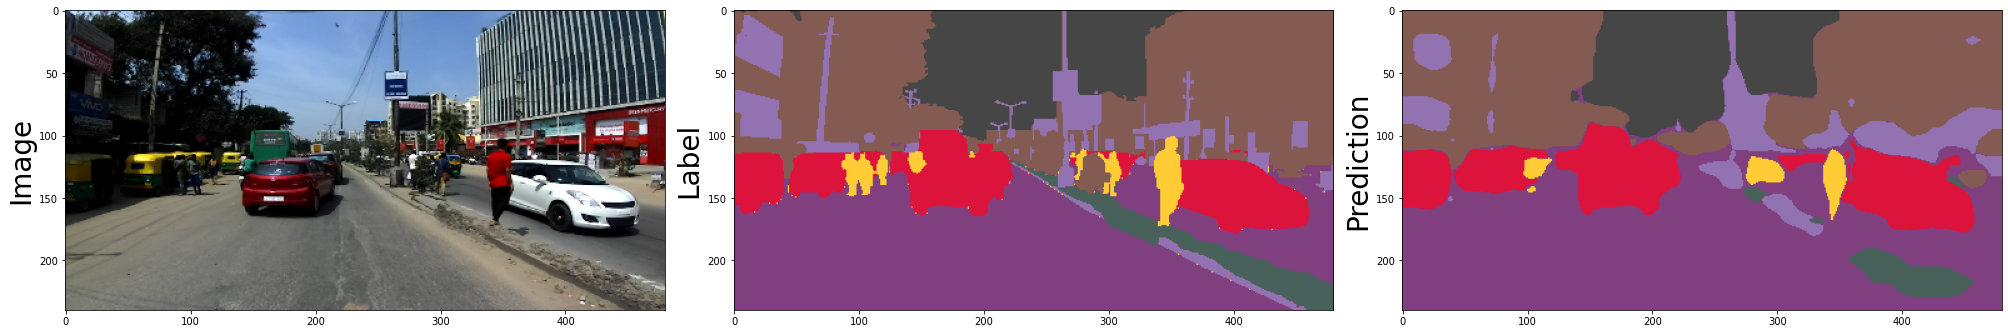


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.5655

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.8725

-----------------------
|  Confusion Matrix   |
-----------------------


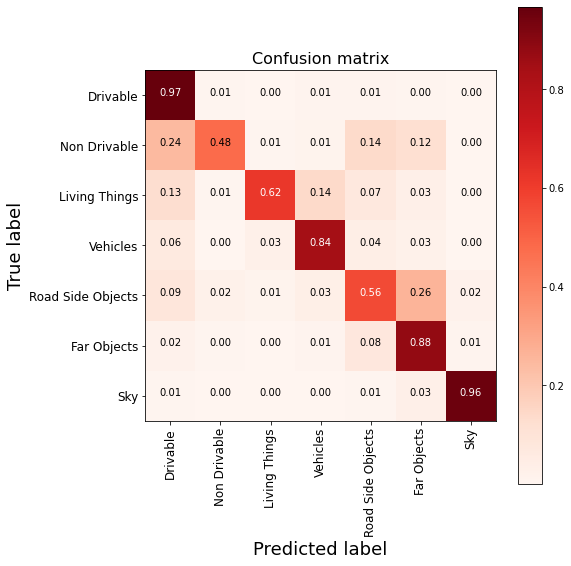

In [ ]:
# Validation Prediction 
Miou, Accuracy, cf_matrix = predict_for("Val_data")

### DeepLabV3 Prediction on Test Data

Total number of samples in Test_data : 4011

Few Segmentation Samples:>>>



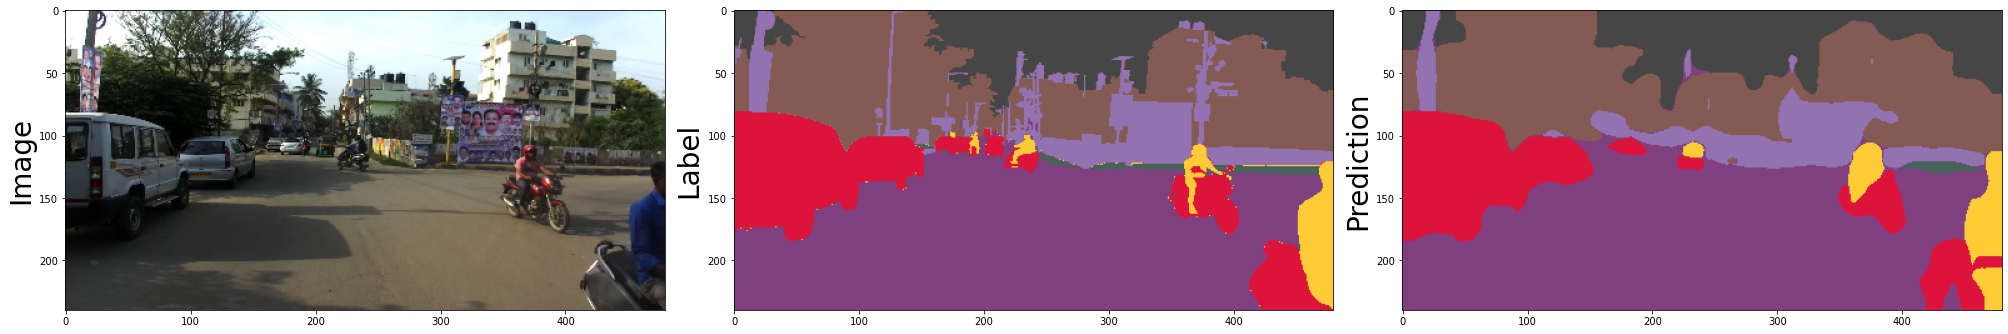


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.5752

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.8832

-----------------------
|  Confusion Matrix   |
-----------------------


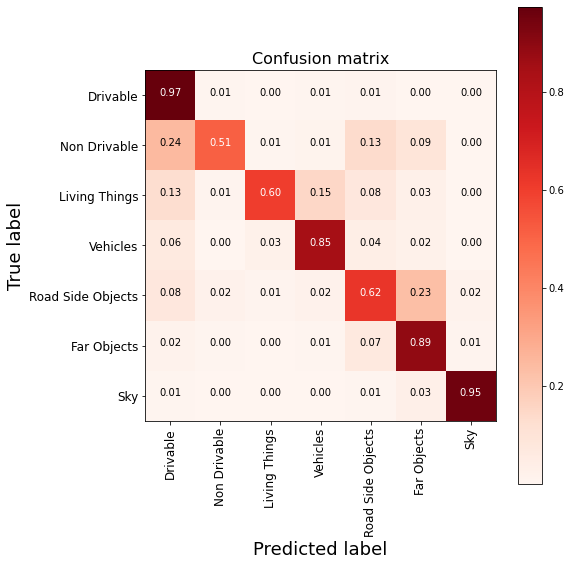

In [ ]:
# Test Prediction 
Miou, Accuracy, cf_matrix = predict_for("Test_data")

### Pretty Tabel


In [ ]:
# https://ptable.readthedocs.io/en/latest/tutorial.html
print("\n\t     Performance Table")
from prettytable import PrettyTable
T = PrettyTable()
T.field_names = ["DeeplabV3","MIOU", "Accuracy"]
T.add_row(["Train ","0.6598","0.9279"])
T.add_row([" ---------- ","----------","----------"])
T.add_row(["Validation ","0.5655","0.8725"])
T.add_row([" ---------- ","----------","----------"])
T.add_row(["Test ","0.5752","0.8832"])
print(T)


	     Performance Table
+--------------+------------+------------+
|  DeeplabV3   |    MIOU    |  Accuracy  |
+--------------+------------+------------+
|    Train     |   0.6598   |   0.9279   |
|  ----------  | ---------- | ---------- |
| Validation   |   0.5655   |   0.8725   |
|  ----------  | ---------- | ---------- |
|    Test      |   0.5752   |   0.8832   |
+--------------+------------+------------+


### <u>**Conclusion:**</u>
* DeeplabV3 chooses to preserve long-range context information and extract dense features in the network for better results. 
* DeeplabV3 solves the problem involving signal decimation and also learn multi-scale contextual features in the neural network.
* DeeplabV3 architecture achieves relatively good performance on Image segmentation when compared to other segmentation models.
* More performance can be obtained by training Models with data in high resolution with more powerful hardware resources.